In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import os,re
from os.path import basename, join
from sklearn.preprocessing import MinMaxScaler
import random

In [3]:
class Dataset_Yahoo_time_window_clean(torch.utils.data.Dataset):
  def __init__(self, length):
        #Initialization
        data = []
        labels = []
        df = pd.DataFrame()
        path = '../Datasets/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/'
        text_files = [f for f in os.listdir(path) if f.endswith('.csv') and not f.endswith('all.csv')]
        scaler = MinMaxScaler(feature_range=(0,1))
        for i,f in enumerate(text_files):
            tmp = pd.read_csv(path+f)
            tmp = tmp.drop(["timestamps","changepoint"],axis = 1)
            tmp["index"] = i
            tmp.set_index('index',inplace = True)
            df = pd.concat([df,tmp])
        df[["trend","noise","seasonality1","seasonality2","seasonality3"]] = scaler.fit_transform(df[["trend","noise","seasonality1","seasonality2","seasonality3"]])
        for index in set(df.index):
            data_tmp = []
            labels_tmp = []
            tmp = df.loc[index]
            tmp.reset_index(inplace = True)
            tmp.drop(["index"],axis = 1, inplace = True)
            anomalous = tmp[tmp["anomaly"] == 1].index.values
            prev = -1
            for anom in anomalous:
                for j in range((anom-prev-1)//length):
                    exc = (anom-prev-1)%length
                    add = tmp.loc[prev+j*length+1+exc:prev+(j+1)*length+exc][["trend","noise","seasonality1","seasonality2","seasonality3"]].values
                    if add.shape[0] :
                        data_tmp.append(add)
                    if add.shape[0] != 10:
                        print(index,prev,anom,j,exc)
                        print(prev+j*length+1+exc,prev+(j+1)*length+exc)
                        print(anomalous)
                    #labels_tmp.append(tmp.loc[prev+j*length+1+exc:prev+(j+1)*length+exc]["anomaly"].values)
                prev = anom
                if len(data_tmp):
                    data.append(data_tmp)
                #labels.append(labels_tmp)
                data_tmp = []
                labels_tmp = []
            for j in range((len(tmp)-prev)//length):
                exc = (len(tmp)-prev-1)%length
                add = tmp.loc[prev+j*length+1+exc:prev+(j+1)*length+exc][["trend","noise","seasonality1","seasonality2","seasonality3"]].values
                if add.shape[0]:
                    data_tmp.append(add)
                #labels_tmp.append(tmp.loc[prev+j*length+1+exc:prev+(j+1)*length+exc]["anomaly"].values)
            if len(data_tmp):
                data.append(data_tmp)
            #labels.append(labels_tmp)
        self.X = data
        #self.Y = labels

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

  def __getitem__(self, index):
        'Generates one sample of data'
        #print(self.Y[index])
        return self.X[index] #, self.Y[index]

In [5]:
class Encoder(nn.Module):
    def __init__(self, batch_size, input_dim, hidden_dim, z_dim):
        super(Encoder,self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lstm1 = nn.LSTM(input_dim,hidden_dim)
        self.fc11 = nn.Linear(hidden_dim,z_dim)
        self.fc12 = nn.Linear(hidden_dim, z_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, input, hidden):
        lstm1_out, hidden = self.lstm1(input, hidden)
        lstm1_out = F.softplus(lstm1_out)
        z_mean = F.tanh(self.fc11(lstm1_out))
        z_log_var = F.tanh(self.fc12(lstm1_out))
        z = self.reparameterize(z_mean,z_log_var)
        return z, z_mean, z_log_var, hidden
    
    def initHidden(self):
        return (torch.zeros(1,10,self.hidden_dim),torch.zeros(1,10,self.hidden_dim))

In [6]:
class Decoder(nn.Module):
    def __init__(self,batch_size, z_dim, hidden_dim, output_dim):
        super(Decoder,self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lstm2 = nn.LSTM(z_dim,hidden_dim)
        self.fc21 = nn.Linear(hidden_dim,output_dim)
        self.fc22 = nn.Linear(hidden_dim, output_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, z, hidden):
        lstm2_out, hidden = self.lstm2(z, hidden)
        lstm2_out = F.softplus(lstm2_out)
        recons_mean = F.tanh(self.fc21(lstm2_out))
        recons_log_var = F.tanh(self.fc22(lstm2_out))
        recons = self.reparameterize(recons_mean,recons_log_var)
        return recons, recons_mean, recons_log_var, hidden
    
    def initHidden(self):
        return (torch.zeros(1,10,self.hidden_dim),torch.zeros(1,10,self.hidden_dim))

In [11]:
def loss_function(recon_x, x, mu, logvar):
    loss = torch.nn.MSELoss(reduce='sum')
    recons = loss(recon_x, x)
    #recons = -0.5 * torch.sum(recons_log_var + torch.mm(torch.mm((x - recons_mean).t(),recons_log_var.inverse()),x - recons_mean) + log(2*np.pi))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recons + KLD, recons, KLD

In [31]:
def train(encoder, decoder, encoder_optimizer, decoder_optimizer,epoch, cum_loss = [], cum_recons_loss = [], cum_kld = []):
    encoder.train()
    decoder.train()
    dtype = torch.float32
    indices = list(range(len(trainset)))
    cum_loss = []
    cum_recons_loss = []
    cum_kld = []
    for e in range(epoch):
        train_loss_epoch = 0
        recons_loss_epoch = 0
        kld_epoch = 0
        random.shuffle(indices)
        for i, series_idx in enumerate(indices):
            encoder_hidden = encoder.initHidden()
            decoder_hidden = decoder.initHidden()
            series = trainset.X[series_idx]
            train_loss_series = 0
            recons_loss_series = 0
            kld_series = 0
            for data in series[:-1]:
                data = torch.from_numpy(data).to(device,dtype = dtype).unsqueeze(0)
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                z, z_mean, z_log_var, encoder_hidden = encoder(data, encoder_hidden)
                recons, recons_mean, recons_log_var, decoder_hidden = decoder(z,decoder_hidden)
                loss, recons_loss, KLD = loss_function(recons_mean, data, z_mean, z_log_var)
                loss.backward(retain_graph=True)
                train_loss_series += loss.item()
                recons_loss_series += recons_loss.item()
                kld_series += KLD
                encoder_optimizer.step()
                decoder_optimizer.step()
            data = series[-1]
            data = torch.from_numpy(data).to(device,dtype = dtype).unsqueeze(0)
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            z, z_mean, z_log_var, encoder_hidden = encoder(data, encoder_hidden)
            recons, recons_mean, recons_log_var, decoder_hidden = decoder(z,decoder_hidden)
            loss, recons_loss, KLD = loss_function(recons_mean, data, z_mean, z_log_var)
            loss.backward()
            train_loss_series += loss.item()
            train_loss_series /= len(series)
            train_loss_epoch += train_loss_series
            recons_loss_series += recons_loss.item()
            recons_loss_series /= len(series)
            recons_loss_epoch += recons_loss_series
            kld_series += KLD
            kld_series /= len(series)
            kld_epoch += kld_series
            encoder_optimizer.step()
            decoder_optimizer.step()
            
            if i % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, recons_loss : {:.6f}, KLD : {:.6f}'.format(
                    e, i * len(data), len(trainset),
                    100. * i / len(trainset),
                    train_loss_series, recons_loss_series, kld_series ))

        train_loss_epoch /= len(trainset)
        recons_loss_epoch /= len(trainset)
        kld_epoch /= len(trainset)
        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              e, train_loss_epoch))
        cum_loss.append(train_loss_epoch)
        cum_recons_loss.append(recons_loss_epoch)
        cum_kld.append(kld_epoch)
    return cum_loss, cum_recons_loss, cum_kld

In [9]:
trainset = Dataset_Yahoo_time_window_clean(length = 10)

/home/victor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/victor/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
device = torch.device('cpu')
encoder = Encoder(batch_size = 1, input_dim = 5, hidden_dim = 128, z_dim = 3)
decoder = Decoder(batch_size= 1, z_dim = 3, hidden_dim= 128, output_dim = 5)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-3)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-3)
epoch = 10
cum_loss, cum_recons_loss, cum_kld = train(encoder,decoder,encoder_optimizer,decoder_optimizer,epoch)

Train Epoch: 0 [0/674 (0%)]	Loss: 0.397253, recons_loss : 0.092722, KLD : 0.304531


# Visualization

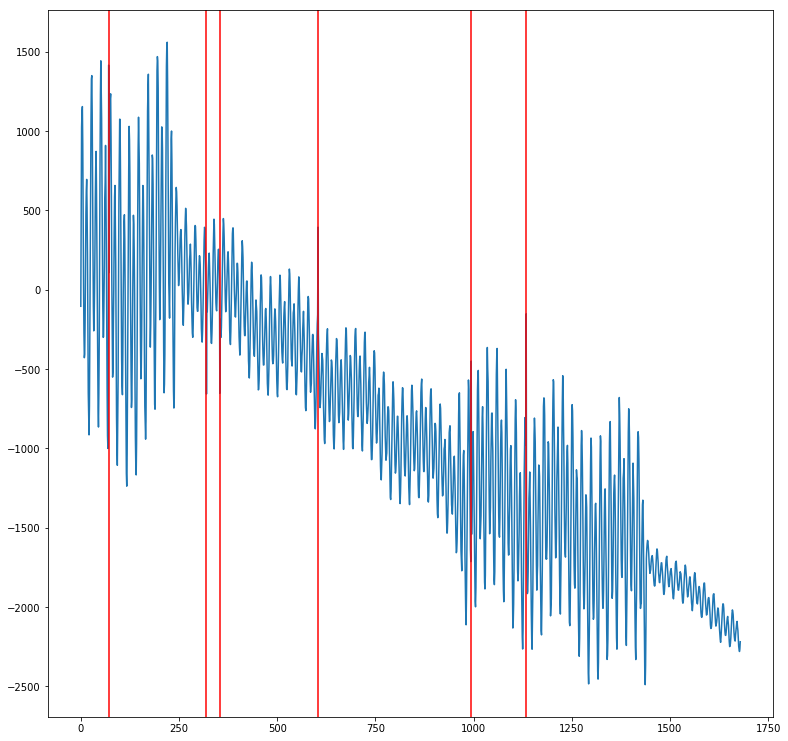

In [4]:
df = pd.read_csv('../Datasets/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS5.csv')
anom = [i for (i,t) in enumerate(df["anomaly"].values) if t == 1]
plt.figure(figsize=(13,13))
plt.plot(df["value"].values)
for anomaly in anom:
    plt.axvline(x = anomaly, color = 'r')